Original code before adaptation https://towardsdfscience.com/social-media-sentiment-analysis-49b395771197

# Social Media Sentiment Analysis on ticker_symbol News dfsets
Sentiment analysis on three datasets related to ticker_symbol news, analyst ratings, and partner headlines.
TextBlob and VADER sentiment analysis tools to classify the text as positive, neutral, or negative.

In [70]:
from flask import Flask, request, jsonify, render_template
from newsapi.newsapi_client import NewsApiClient
import dotenv
from datetime import datetime, timedelta
from dotenv import load_dotenv
import os
import pandas as pd
import re
import textblob
from textblob import TextBlob
import vaderSentiment
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import matplotlib.pyplot as plt
import seaborn as sns
import requests
import json
import io
import base64
import langdetect
from langdetect import detect

ticker_symbol = "MSFT"

env = '.env'
load_dotenv(env)

API_KEY = os.getenv('API_KEY')
newsapi = NewsApiClient(api_key='API_KEY')

today = datetime.now()
one_week_ago = today - timedelta(days=7)
from_date = one_week_ago.strftime('%Y-%m-%d')
to_date = today.strftime('%Y-%m-%d')

import requests
import pandas as pd
import json 

url= f"https://newsapi.org/v2/everything?q={ticker_symbol}&from={from_date}&to={to_date}&sortBy=popularity&apiKey={API_KEY}"
# Make a GET request to the API
response = requests.get(url)

# Check if the request was successful
if response.status_code == 200:
    # Parse the JSON data
    data = response.json() 
    
else:
    print("Failed to retrieve data:", response.status_code)

df = pd.DataFrame(data)
df

,status,totalResults,articles
0,ok,66,"{'source': {'id': None, 'name': 'Quartz India'..."
1,ok,66,"{'source': {'id': None, 'name': 'Quartz India'..."
2,ok,66,"{'source': {'id': None, 'name': 'Quartz India'..."
3,ok,66,"{'source': {'id': None, 'name': 'Quartz India'..."
4,ok,66,"{'source': {'id': None, 'name': 'Quartz India'..."
...,...,...,...
61,ok,66,"{'source': {'id': None, 'name': 'Freerepublic...."
62,ok,66,"{'source': {'id': None, 'name': 'Stockcharts.c..."
63,ok,66,"{'source': {'id': None, 'name': 'Askubuntu.com..."
64,ok,66,"{'source': {'id': None, 'name': 'Fark.com'}, '..."


In [71]:
# Normalize the JSON column
details_df = pd.json_normalize(df["articles"])

# Concatenate the normalized columns with the original DataFrame
df = pd.concat([df.drop(columns=["articles",]), details_df], axis=1)
df = df[['source.name', 'title', 'publishedAt']]

# Rename columns
df.rename(columns={'source.name': 'source', 'publishedAt': 'date'}, inplace=True)

# Convert date to yyyy/mm/dd format
df['date'] = pd.to_datetime(df['date']).dt.strftime('%Y/%m/%d')
df.shape

(66, 3)

Exclude foreign languages

In [72]:
from langdetect import detect

# Get the 10 most recent entries

# Step 1: Filter the DataFrame to include only English rows
def is_english(text):
    try:
        # Detect the language of the text
        return detect(text) == 'en'
    except:
        # If language detection fails, assume it's not English
        return False

# Filter the DataFrame to keep only English titles
df = df[df['title'].apply(is_english)]
df.shape

(63, 3)

In [73]:
import pandas as pd
import numpy as np
import re
from textblob import TextBlob
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import seaborn as sns
import matplotlib.pyplot as plt

# Initialize the VADER sentiment analyzer
analyzer = SentimentIntensityAnalyzer()


Text Preprocessing

In [74]:
def preprocess_text(text):
    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    # Remove special characters and numbers
    text = re.sub(r'\@\w+|\#|\d+', '', text)
    # Remove punctuation
    text = re.sub(r'[^\w\s]', '', text)
    # Convert to lowercase
    text = text.lower()
    return text

# Apply text preprocessing to each dataset
df['title'] = df['title'].apply(lambda x: preprocess_text(x))


Sentiment Analysis

In [75]:
# Define a function to classify sentiment using TextBlob and VADER
def analyze_sentiment(text):
    # Use TextBlob for polarity
    blob = TextBlob(text)
    polarity = blob.sentiment.polarity
    
    # Use VADER for compound score
    vader_score = analyzer.polarity_scores(text)
    compound = vader_score['compound']
    
    # Define positive, neutral, and negative based on compound score
    if compound >= 0.05:
        sentiment = 'positive'
    elif compound <= -0.05:
        sentiment = 'negative'
    else:
        sentiment = 'neutral'
    
    return sentiment, polarity, compound

df[['sentiment', 'polarity', 'compound']] = df['title'].apply(
        lambda x: analyze_sentiment(x)).apply(pd.Series)

# Display results for verification
display(df[['title', 'sentiment', 'polarity', 'compound']])


,title,sentiment,polarity,compound
0,microsoft and nasa have a new ai tool to put s...,neutral,0.136364,0.0000
1,microsofts president has a warning about china,negative,0.000000,-0.3400
2,googles gemini ai chatbot now has an iphone app,neutral,0.000000,0.0000
3,openai is launching an ai agent that can do wo...,neutral,0.000000,0.0000
4,trees dont grow to the sky nelson peltz says t...,positive,0.000000,0.6486
...,...,...,...,...
61,microsoft edge antitrump,neutral,0.000000,0.0000
62,riding the stock markets wave how to maximize ...,positive,0.000000,0.3400
63,python and pip package location,neutral,0.000000,0.0000
64,so if im reading this right trump appointed ju...,positive,0.196429,0.5267


Vizualization

/tmp/ipykernel_2802/36755253.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=df['sentiment'].value_counts().index,


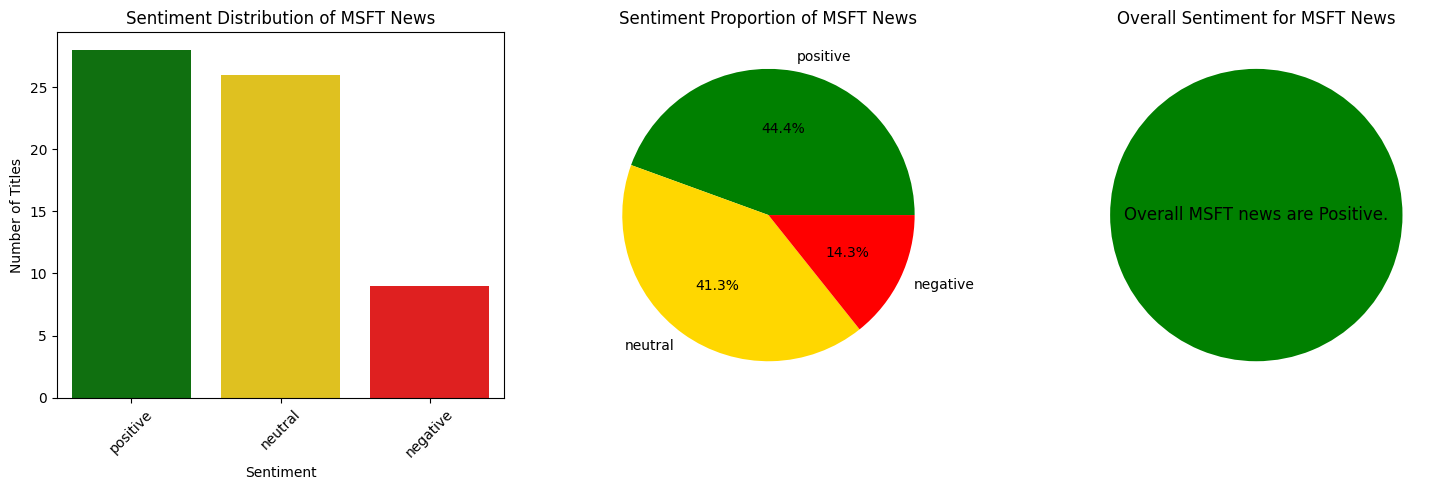

In [106]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Define color legend
legend_labels = [
    'Positive (>= 0.05)',
    'Neutral (-0.05 to 0.05)',
    'Negative (<= -0.05)'
]
legend_colors = ['green', 'gold', 'red']
handles = [plt.Line2D([0], [0], color=color, lw=4) for color in legend_colors]

# Set up the 1x3 layout for all the visualizations
fig, axes = plt.subplots(1, 3, figsize=(15, 5))  # 1 row, 3 columns

# Sentiment Distribution Bar Chart
sns.barplot(x=df['sentiment'].value_counts().index, 
            y=df['sentiment'].value_counts().values, 
            ax=axes[0], 
            palette=legend_colors)
axes[0].set_title(f'Sentiment Distribution of {ticker_symbol} News')
axes[0].set_xlabel('Sentiment')
axes[0].set_ylabel('Number of Titles')
axes[0].tick_params(axis='x', rotation=45)

# Pie Chart for Sentiment Proportion
sentiment_counts = df['sentiment'].value_counts()
axes[1].pie(sentiment_counts, labels=sentiment_counts.index, autopct='%1.1f%%', 
            colors=legend_colors)
axes[1].set_title(f'Sentiment Proportion of {ticker_symbol} News')

# Average Compound Score Gauge-like Diagram
# Step 1: Calculate the average compound score
avg_compound = df['compound'].mean()

# Step 2: Determine overall sentiment and set color
if avg_compound >= 0.05:
    overall_sentiment = 'Positive'
    color = 'green'
elif avg_compound <= -0.05:
    overall_sentiment = 'Negative'
    color = 'red'
else:
    overall_sentiment = 'Neutral'
    color = 'gold'

# Step 3: Create a gauge-like graphic
wedges, _ = axes[2].pie([1], colors=[color], radius=1)

# Add an annotation to indicate the overall sentiment
axes[2].text(0, 0.1, overall_sentiment, ha='center', va='center', fontsize=24, fontweight='bold', color=color)

# Add the phrase to state the overall sentiment clearly
axes[2].text(0, 0, f"Overall {ticker_symbol} news are {overall_sentiment}.", 
             ha='center', va='center', fontsize=12, color='black')

axes[2].set_title(f'Overall Sentiment for {ticker_symbol} News')

# Adjust layout for better spacing
plt.tight_layout()
plt.show()


Save datasets

In [ ]:
df.to_csv("data/processed/processed_sentiment.csv", index=False)
